In [23]:
import pandas as pd
import numpy as np
import networkx as nx

from dataclasses import dataclass
from itertools import combinations

# Read in the data
css_papers = pd.read_excel('CCS_Papers.xlsx', index_col=0)
Authors = pd.read_excel('AuthorDatawithField.xlsx',index_col=0)

KnownAuthors = Authors.AuthorID.to_list()

In [24]:
css_papers.columns

Index(['paperId', 'title', 'year', 'externalIds', 'citationCount', 'authors',
       's2FieldsOfStudy', 'AuthorIDs', 'Category', 'author_field'],
      dtype='object')

In [25]:
# Create edges dataclass
@dataclass
class netowrk_edge:
    Author1: str
    Author2: str
    Weight: int

    def get_as_tuple(self):
        return (self.Author1, self.Author2,  self.Weight)


def CheackIfEdgeExists(Edges, Author1, Author2):
    for edge in Edges:
        if edge.Author1 == Author1 and edge.Author2 == Author2:
            return True
        if edge.Author1 == Author2 and edge.Author2 == Author1:
            return True
    return False



In [26]:
Edges = []

for idx, paper in css_papers.iterrows():
    Authors_pairs = combinations(eval(paper['AuthorIDs']),2)

    for Author1, Author2 in Authors_pairs:
        #if Author1 in KnownAuthors and Author2 in KnownAuthors:
        if not CheackIfEdgeExists(Edges, Author1, Author2):
            Edges.append(netowrk_edge(Author1, Author2, 1))
        else:
            for edge in Edges:
                if edge.Author1 == Author1 and edge.Author2 == Author2:
                    edge.Weight += 1
                if edge.Author1 == Author2 and edge.Author2 == Author1:
                    edge.Weight += 1



In [27]:
# Create undirected graph

G = nx.Graph()

# Add edges to the graph
G.add_weighted_edges_from([edge.get_as_tuple() for edge in Edges])

node_list = list(G.nodes)

In [30]:
G.edges(data=True)

EdgeDataView([(22446549, 144240725, {'weight': 6}), (22446549, 1733303, {'weight': 6}), (22446549, 144988054, {'weight': 2}), (22446549, 3241784, {'weight': 2}), (144240725, 1733303, {'weight': 11}), (144240725, 144988054, {'weight': 3}), (144240725, 3241784, {'weight': 2}), (144240725, 50593657, {'weight': 1}), (144240725, 1782658, {'weight': 1}), (144240725, 2054860511, {'weight': 1}), (144240725, 46886279, {'weight': 1}), (144240725, 144065562, {'weight': 2}), (144240725, 1729928, {'weight': 1}), (144240725, 1743043, {'weight': 2}), (144240725, 35497150, {'weight': 1}), (144240725, 33570565, {'weight': 1}), (144240725, 31796970, {'weight': 1}), (144240725, 145192169, {'weight': 1}), (144240725, 2618549, {'weight': 2}), (144240725, 1388020502, {'weight': 1}), (144240725, 2101349323, {'weight': 1}), (1733303, 144988054, {'weight': 3}), (1733303, 3241784, {'weight': 2}), (1733303, 51965804, {'weight': 8}), (1733303, 9957987, {'weight': 10}), (1733303, 1710491, {'weight': 8}), (1733303,

In [31]:
def get_name_from_alias(aliases):
    for alias in aliases:
        if len(alias.split(" ")[0]) < 3:
            continue
        else:
            return alias    

In [32]:
for idx,author in enumerate(node_list):
    try:
        names = eval(Authors[Authors['AuthorID'] == author]['Aliases'].values.tolist()[0])
        name = get_name_from_alias(names)
    except:
        name = "No Name"
    try:
        field = Authors[Authors['AuthorID'] == author].Field.values.tolist()[0]
    except:
        field = "No Field"
    
    Paper_IDs_list = [eval(IDs) for IDs in css_papers['AuthorIDs']]

    Sorting_bool = [author in IDs for IDs in Paper_IDs_list]

    AuthorPapers = css_papers[Sorting_bool]

    median_count = AuthorPapers['citationCount'].median()

    n_papers = len(AuthorPapers)

    firt_paper_year = AuthorPapers['year'].min()

    # fill node attributes
    G.nodes[author]['names'] = name
    G.nodes[author]['field'] = field
    G.nodes[author]['median_count'] = median_count
    G.nodes[author]['n_papers'] = n_papers
    G.nodes[author]['first_paper_year'] = firt_paper_year
    G.nodes[author]['count'] = Authors[Authors['AuthorID'] == author]['CitationCount'].values.tolist()


In [33]:
# Save Netowrk
import json

json_dic = json.dumps(nx.node_link_data(G))

with open('Network.json', 'w') as outfile:
    json.dump(json_dic, outfile)


In [34]:
# Load Netowrk
import json

with open('Network.json', 'r') as infile:
    json_dict = json.load(infile)

G = nx.node_link_graph(json.loads(json_dict))

Number of nodes:  1210
Number of edges:  3500
Density:  0.004785048773318568


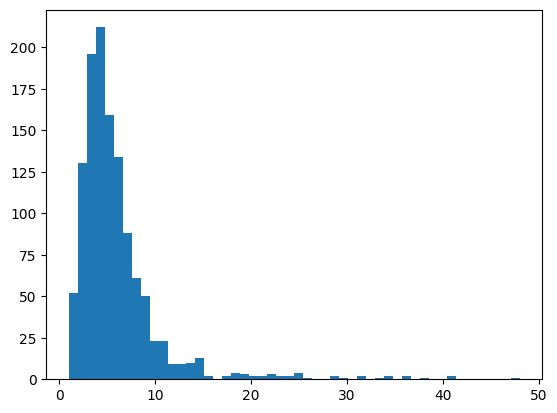

Mean degree:  5.785123966942149
Median degree:  5.0
Max degree:  48
Min degree:  1
mode degree:  4
Mean strength:  8.35206611570248
Median strength:  5.0
Max strength:  124
Min strength:  1
mode strength:  4
{'names': 'Diego Garlaschelli', 'field': 'Computer Science', 'median_count': 19.0, 'n_papers': 33, 'first_paper_year': 2009.0, 'count': [5555]}
{'names': 'Frank Schweitzer', 'field': 'Computer Science', 'median_count': 10.0, 'n_papers': 53, 'first_paper_year': 2009.0, 'count': [10401]}
{'names': "Fabr'icio Benevenuto", 'field': 'Computer Science', 'median_count': 9.0, 'n_papers': 17, 'first_paper_year': 2011.0, 'count': [11124]}
{'names': 'Scott W. Cunningham', 'field': 'Computer Science', 'median_count': 4.0, 'n_papers': 26, 'first_paper_year': 2009.0, 'count': [1588]}
{'names': 'Fariba Karimi', 'field': 'Computer Science', 'median_count': 9.0, 'n_papers': 17, 'first_paper_year': 2013.0, 'count': [1112]}


In [36]:
# Analyse network

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

# Density

max_edges = sum([_ for _ in range(G.number_of_nodes())])
density = G.number_of_edges()/max_edges

print("Density: ", density)


# Degree distribution

import matplotlib.pyplot as plt
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50)
plt.show()
# Summary Statistics of degree distribution
print("Mean degree: ", np.mean(degrees))
print("Median degree: ", np.median(degrees))
print("Max degree: ", np.max(degrees))
print("Min degree: ", np.min(degrees))
print("mode degree: ", max(set(degrees), key=degrees.count))

# Summary Statistics of strength distribution
strengths = [G.degree(n, weight='weight') for n in G.nodes()]
print("Mean strength: ", np.mean(strengths))
print("Median strength: ", np.median(strengths))
print("Max strength: ", np.max(strengths))
print("Min strength: ", np.min(strengths))
print("mode strength: ", max(set(strengths), key=strengths.count))


# Get top 5 nodes by degree
top_5_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]
for node in top_5_nodes:
    print(G.nodes[node[0]])

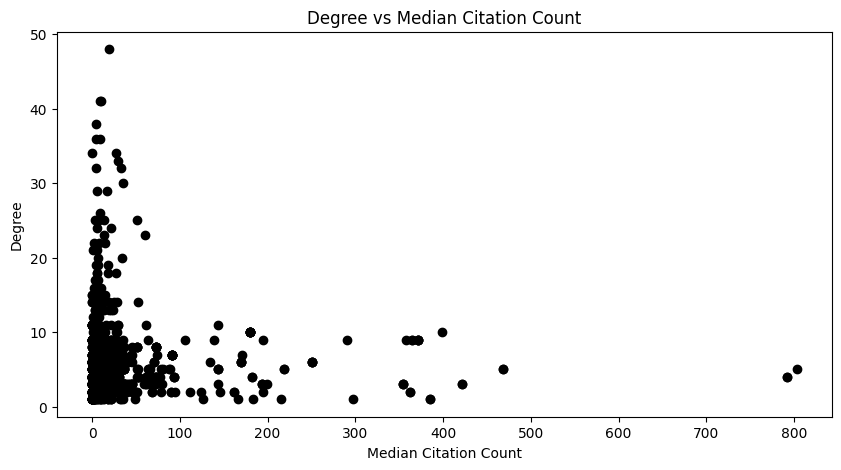

SignificanceResult(statistic=0.0521919008637985, pvalue=0.0695456295662704)

In [22]:
# Plot Degree distribution

median_count = [G.nodes[node]['median_count'] for node in G.nodes()]
degrees = [G.degree(n) for n in G.nodes()]

fig,axs = plt.subplots(1,1, figsize=(10,5))

axs.plot(median_count, degrees, 'o', color='black')

# Set axis to log
#axs.set_xscale('log')
#axs.set_yscale('log')

# Set axis labels
axs.set_xlabel('Median Citation Count')
axs.set_ylabel('Degree')

# Set title
axs.set_title('Degree vs Median Citation Count')

plt.show()


# Calulate spearman correlation
from scipy.stats import spearmanr

spearmanr(median_count, degrees)